# [GD-01] 없다면 어떻게 될까? (ResNet Ablation Study)

## 00. import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()


## 01. Dataset

In [2]:
BATCH_SIZE = 32  # 256
EPOCH = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

In [3]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
ds_info.features["label"].num_classes  # 2


2

In [6]:
ds_info.features["label"].names  # ['cat', 'dog']


['cat', 'dog']

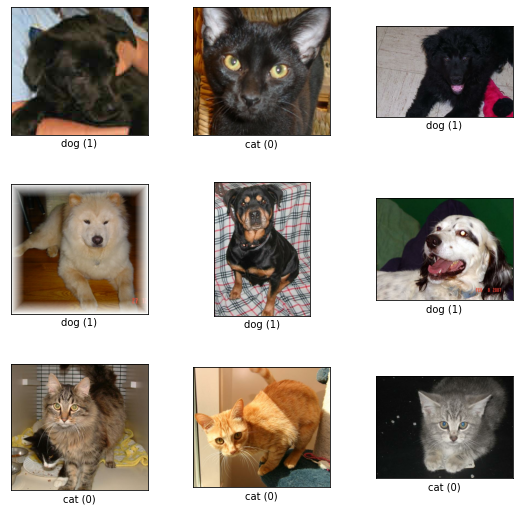

In [7]:
fig = tfds.show_examples(ds_train, ds_info)


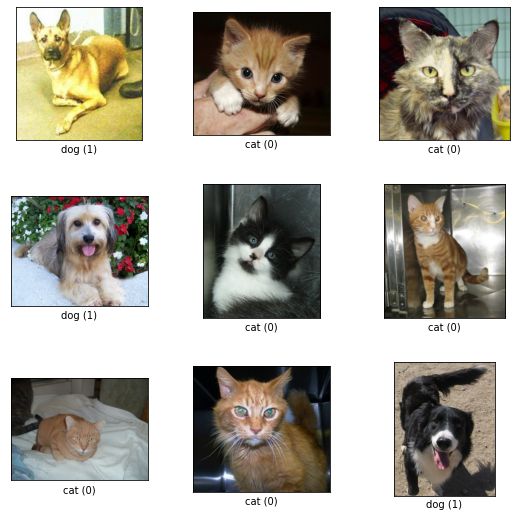

In [8]:
fig = tfds.show_examples(ds_test, ds_info)


In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:

ds_train = apply_normalize_on_dataset(ds_train, batch_size=32)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=32)

In [12]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


## 02. model

In [13]:
def conv_batch(layer, 
               channel, 
               kernel_size, 
               padding='same', 
               strides=1, 
               activation='relu', 
               name='0'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

In [14]:
def build_plain_block(input_layer, 
                      block_num=0, 
                      num_cnn=3, 
                      channel=64, 
                      is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

In [15]:
def build_plain(num_cnn_list, 
                channel_list, 
                is_50=True, 
                cats_vs_dogs=False, 
                input_shape=(32,32,3), 
                num_classes=2, 
                name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

In [16]:
def build_residual_block(input_layer, 
                         block_num=0, 
                         num_cnn=3, 
                         channel=64, 
                         is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

In [17]:
def build_resnet(num_cnn_list, 
                 channel_list, is_50=True,  
                 input_shape=(32,32,3),  
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)

    output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

In [18]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

In [19]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

In [20]:
resnet_34 = build_resnet(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

In [21]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## 03. Train

In [22]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/654 [>.............................] - ETA: 1:41 - loss: 2.3339 - accuracy: 0.5054

 38/654 [>.............................] - ETA: 1:39 - loss: 2.3574 - accuracy: 0.4910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/654 [====>.........................] - ETA: 1:27 - loss: 2.2818 - accuracy: 0.5050

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/654 [=============>................] - ETA: 54s - loss: 2.1924 - accuracy: 0.5055

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/654 [==============>...............] - ETA: 53s - loss: 2.1890 - accuracy: 0.5053

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/654 [==============>...............] - ETA: 51s - loss: 2.1852 - accuracy: 0.5041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/654 [===============>..............] - ETA: 47s - loss: 2.1760 - accuracy: 0.5043

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/654 [================>.............] - ETA: 46s - loss: 2.1741 - accuracy: 0.5040

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/654 [=========================>....] - ETA: 12s - loss: 2.1106 - accuracy: 0.5090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


611/654 [===========================>..] - ETA: 7s - loss: 2.1005 - accuracy: 0.5114

619/654 [===========================>..] - ETA: 5s - loss: 2.0982 - accuracy: 0.5121

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.5142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 167s 189ms/step - loss: 2.0877 - accuracy: 0.5142 - val_loss: 1.9514 - val_accuracy: 0.5352
Epoch 2/10
 42/654 [>.............................] - ETA: 1:54 - loss: 1.8849 - accuracy: 0.5526

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


248/654 [==========>...................] - ETA: 1:11 - loss: 1.8340 - accuracy: 0.5544

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


258/654 [==========>...................] - ETA: 1:09 - loss: 1.8315 - accuracy: 0.5542

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/654 [===========>..................] - ETA: 1:06 - loss: 1.8282 - accuracy: 0.5532

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


300/654 [============>.................] - ETA: 1:02 - loss: 1.8213 - accuracy: 0.5540

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


306/654 [=============>................] - ETA: 1:00 - loss: 1.8199 - accuracy: 0.5533

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


505/654 [======================>.......] - ETA: 25s - loss: 1.7743 - accuracy: 0.5534

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


540/654 [=======================>......] - ETA: 19s - loss: 1.7672 - accuracy: 0.5530

548/654 [========================>.....] - ETA: 18s - loss: 1.7654 - accuracy: 0.5535

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


624/654 [===========================>..] - ETA: 5s - loss: 1.7497 - accuracy: 0.5511

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.7437 - accuracy: 0.5526

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 188ms/step - loss: 1.7437 - accuracy: 0.5526 - val_loss: 1.6360 - val_accuracy: 0.5161
Epoch 3/10
175/654 [=======>......................] - ETA: 1:23 - loss: 1.5727 - accuracy: 0.5691

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


187/654 [=======>......................] - ETA: 1:20 - loss: 1.5709 - accuracy: 0.5672

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


201/654 [========>.....................] - ETA: 1:18 - loss: 1.5682 - accuracy: 0.5665

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


228/654 [=========>....................] - ETA: 1:13 - loss: 1.5651 - accuracy: 0.5648

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/654 [=========>....................] - ETA: 1:12 - loss: 1.5643 - accuracy: 0.5641

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


435/654 [==================>...........] - ETA: 37s - loss: 1.5284 - accuracy: 0.5690

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


467/654 [====================>.........] - ETA: 32s - loss: 1.5233 - accuracy: 0.5695

478/654 [====================>.........] - ETA: 30s - loss: 1.5209 - accuracy: 0.5706

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


551/654 [========================>.....] - ETA: 17s - loss: 1.5086 - accuracy: 0.5723

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.4912 - accuracy: 0.5715

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 187ms/step - loss: 1.4912 - accuracy: 0.5715 - val_loss: 1.3988 - val_accuracy: 0.5547
Epoch 4/10
103/654 [===>..........................] - ETA: 1:35 - loss: 1.3753 - accuracy: 0.5850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


117/654 [====>.........................] - ETA: 1:32 - loss: 1.3725 - accuracy: 0.5855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


126/654 [====>.........................] - ETA: 1:31 - loss: 1.3723 - accuracy: 0.5831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


153/654 [======>.......................] - ETA: 1:26 - loss: 1.3671 - accuracy: 0.5852

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


159/654 [======>.......................] - ETA: 1:25 - loss: 1.3662 - accuracy: 0.5839

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/654 [===============>..............] - ETA: 50s - loss: 1.3385 - accuracy: 0.5884

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


392/654 [================>.............] - ETA: 45s - loss: 1.3338 - accuracy: 0.5901

405/654 [=================>............] - ETA: 43s - loss: 1.3326 - accuracy: 0.5891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


477/654 [====================>.........] - ETA: 30s - loss: 1.3241 - accuracy: 0.5857

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.3010 - accuracy: 0.5865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 188ms/step - loss: 1.3010 - accuracy: 0.5865 - val_loss: 2.5790 - val_accuracy: 0.5018
Epoch 5/10
 31/654 [>.............................] - ETA: 1:47 - loss: 1.2135 - accuracy: 0.5796

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 44/654 [=>............................] - ETA: 1:45 - loss: 1.2128 - accuracy: 0.5831

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 57/654 [=>............................] - ETA: 1:42 - loss: 1.2149 - accuracy: 0.5822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/654 [==>...........................] - ETA: 1:38 - loss: 1.2100 - accuracy: 0.5856

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/654 [===>..........................] - ETA: 1:37 - loss: 1.2076 - accuracy: 0.5878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


290/654 [============>.................] - ETA: 1:02 - loss: 1.1909 - accuracy: 0.5890

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


321/654 [=============>................] - ETA: 57s - loss: 1.1863 - accuracy: 0.5919

333/654 [==============>...............] - ETA: 55s - loss: 1.1844 - accuracy: 0.5939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


405/654 [=================>............] - ETA: 43s - loss: 1.1770 - accuracy: 0.5928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


615/654 [===========================>..] - ETA: 6s - loss: 1.1522 - accuracy: 0.6014

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


625/654 [===========================>..] - ETA: 5s - loss: 1.1510 - accuracy: 0.6027

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


638/654 [============================>.] - ETA: 2s - loss: 1.1499 - accuracy: 0.6026

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.1479 - accuracy: 0.6034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 187ms/step - loss: 1.1479 - accuracy: 0.6034 - val_loss: 1.1761 - val_accuracy: 0.5764
Epoch 6/10
 11/654 [..............................] - ETA: 1:50 - loss: 1.0466 - accuracy: 0.6619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 17/654 [..............................] - ETA: 1:49 - loss: 1.0494 - accuracy: 0.6434

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/654 [=========>....................] - ETA: 1:15 - loss: 1.0695 - accuracy: 0.6140

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/654 [==========>...................] - ETA: 1:10 - loss: 1.0650 - accuracy: 0.6153

262/654 [===========>..................] - ETA: 1:07 - loss: 1.0624 - accuracy: 0.6180

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


335/654 [==============>...............] - ETA: 55s - loss: 1.0521 - accuracy: 0.6266

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


541/654 [=======================>......] - ETA: 19s - loss: 1.0308 - accuracy: 0.6365

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


555/654 [========================>.....] - ETA: 17s - loss: 1.0294 - accuracy: 0.6370

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


564/654 [========================>.....] - ETA: 15s - loss: 1.0285 - accuracy: 0.6377

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


591/654 [==========================>...] - ETA: 10s - loss: 1.0275 - accuracy: 0.6369

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


597/654 [==========================>...] - ETA: 9s - loss: 1.0271 - accuracy: 0.6370 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0228 - accuracy: 0.6389

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 122s 187ms/step - loss: 1.0228 - accuracy: 0.6389 - val_loss: 1.0678 - val_accuracy: 0.5104
Epoch 7/10
148/654 [=====>........................] - ETA: 1:27 - loss: 0.9502 - accuracy: 0.6687

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/654 [=======>......................] - ETA: 1:22 - loss: 0.9470 - accuracy: 0.6701

187/654 [=======>......................] - ETA: 1:20 - loss: 0.9473 - accuracy: 0.6681

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/654 [===========>..................] - ETA: 1:07 - loss: 0.9502 - accuracy: 0.6572

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


470/654 [====================>.........] - ETA: 31s - loss: 0.9344 - accuracy: 0.6603

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


480/654 [=====================>........] - ETA: 30s - loss: 0.9332 - accuracy: 0.6604

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


493/654 [=====================>........] - ETA: 27s - loss: 0.9309 - accuracy: 0.6618

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


520/654 [======================>.......] - ETA: 23s - loss: 0.9282 - accuracy: 0.6631

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


526/654 [=======================>......] - ETA: 22s - loss: 0.9280 - accuracy: 0.6627

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9213 - accuracy: 0.6620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 122s 187ms/step - loss: 0.9213 - accuracy: 0.6620 - val_loss: 0.9374 - val_accuracy: 0.5784
Epoch 8/10
 73/654 [==>...........................] - ETA: 1:40 - loss: 0.8852 - accuracy: 0.6635

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


105/654 [===>..........................] - ETA: 1:34 - loss: 0.8789 - accuracy: 0.6724

116/654 [====>.........................] - ETA: 1:32 - loss: 0.8755 - accuracy: 0.6736

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


192/654 [=======>......................] - ETA: 1:20 - loss: 0.8655 - accuracy: 0.6767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


398/654 [=================>............] - ETA: 44s - loss: 0.8517 - accuracy: 0.6803

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


409/654 [=================>............] - ETA: 42s - loss: 0.8511 - accuracy: 0.6802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


421/654 [==================>...........] - ETA: 40s - loss: 0.8498 - accuracy: 0.6807

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


448/654 [===================>..........] - ETA: 35s - loss: 0.8466 - accuracy: 0.6825

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


454/654 [===================>..........] - ETA: 34s - loss: 0.8458 - accuracy: 0.6835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.6852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 188ms/step - loss: 0.8377 - accuracy: 0.6852 - val_loss: 1.1462 - val_accuracy: 0.5854
Epoch 9/10
  3/654 [..............................] - ETA: 1:51 - loss: 0.7938 - accuracy: 0.6354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/654 [>.............................] - ETA: 1:47 - loss: 0.8118 - accuracy: 0.6866

 45/654 [=>............................] - ETA: 1:45 - loss: 0.8088 - accuracy: 0.6854

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/654 [====>.........................] - ETA: 1:32 - loss: 0.7952 - accuracy: 0.6971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/654 [=============>................] - ETA: 56s - loss: 0.7801 - accuracy: 0.7057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/654 [==============>...............] - ETA: 54s - loss: 0.7790 - accuracy: 0.7054

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/654 [===============>..............] - ETA: 52s - loss: 0.7793 - accuracy: 0.7046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/654 [================>.............] - ETA: 47s - loss: 0.7779 - accuracy: 0.7052

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/654 [================>.............] - ETA: 46s - loss: 0.7771 - accuracy: 0.7053

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


584/654 [=========================>....] - ETA: 12s - loss: 0.7663 - accuracy: 0.7090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


617/654 [===========================>..] - ETA: 6s - loss: 0.7650 - accuracy: 0.7090

626/654 [===========================>..] - ETA: 4s - loss: 0.7643 - accuracy: 0.7095

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.7102

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 187ms/step - loss: 0.7629 - accuracy: 0.7102 - val_loss: 0.9996 - val_accuracy: 0.5681
Epoch 10/10
 48/654 [=>............................] - ETA: 1:44 - loss: 0.7425 - accuracy: 0.7109

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/654 [==========>...................] - ETA: 1:09 - loss: 0.7332 - accuracy: 0.7133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


265/654 [===========>..................] - ETA: 1:07 - loss: 0.7316 - accuracy: 0.7142

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


278/654 [===========>..................] - ETA: 1:05 - loss: 0.7287 - accuracy: 0.7167

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


305/654 [============>.................] - ETA: 1:00 - loss: 0.7289 - accuracy: 0.7169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


311/654 [=============>................] - ETA: 59s - loss: 0.7281 - accuracy: 0.7171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


514/654 [======================>.......] - ETA: 24s - loss: 0.7247 - accuracy: 0.7160

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/654 [=======================>......] - ETA: 19s - loss: 0.7239 - accuracy: 0.7160

554/654 [========================>.....] - ETA: 17s - loss: 0.7225 - accuracy: 0.7172

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


630/654 [===========================>..] - ETA: 4s - loss: 0.7208 - accuracy: 0.7163

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.7161

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 123s 187ms/step - loss: 0.7201 - accuracy: 0.7161 - val_loss: 0.7266 - val_accuracy: 0.7404


In [23]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/654 [>.............................] - ETA: 2:50 - loss: 5.5678 - accuracy: 0.5024

 38/654 [>.............................] - ETA: 2:47 - loss: 5.5231 - accuracy: 0.4918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/654 [====>.........................] - ETA: 2:29 - loss: 5.4285 - accuracy: 0.5065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/654 [=============>................] - ETA: 1:31 - loss: 5.1559 - accuracy: 0.4994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/654 [==============>...............] - ETA: 1:28 - loss: 5.1442 - accuracy: 0.5008

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/654 [==============>...............] - ETA: 1:25 - loss: 5.1328 - accuracy: 0.4986

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/654 [===============>..............] - ETA: 1:17 - loss: 5.1050 - accuracy: 0.4994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/654 [================>.............] - ETA: 1:16 - loss: 5.0988 - accuracy: 0.4996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/654 [=========================>....] - ETA: 20s - loss: 4.9093 - accuracy: 0.5007

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


609/654 [==========================>...] - ETA: 12s - loss: 4.8834 - accuracy: 0.5011

620/654 [===========================>..] - ETA: 9s - loss: 4.8739 - accuracy: 0.5008

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 4.8448 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 208s 294ms/step - loss: 4.8448 - accuracy: 0.5010 - val_loss: 4.2913 - val_accuracy: 0.4883
Epoch 2/10
 41/654 [>.............................] - ETA: 2:47 - loss: 4.2613 - accuracy: 0.5373

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


246/654 [==========>...................] - ETA: 1:51 - loss: 4.1204 - accuracy: 0.5127

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


259/654 [==========>...................] - ETA: 1:48 - loss: 4.1115 - accuracy: 0.5128

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


270/654 [===========>..................] - ETA: 1:45 - loss: 4.1041 - accuracy: 0.5133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


297/654 [============>.................] - ETA: 1:37 - loss: 4.0858 - accuracy: 0.5166

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


303/654 [============>.................] - ETA: 1:35 - loss: 4.0818 - accuracy: 0.5173

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


504/654 [======================>.......] - ETA: 41s - loss: 3.9496 - accuracy: 0.5281

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


537/654 [=======================>......] - ETA: 31s - loss: 3.9293 - accuracy: 0.5282

549/654 [========================>.....] - ETA: 28s - loss: 3.9216 - accuracy: 0.5290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


621/654 [===========================>..] - ETA: 9s - loss: 3.8772 - accuracy: 0.5302

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 3.8561 - accuracy: 0.5327

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 3.8561 - accuracy: 0.5327 - val_loss: 3.4615 - val_accuracy: 0.4939
Epoch 3/10
175/654 [=======>......................] - ETA: 2:11 - loss: 3.3570 - accuracy: 0.5634

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


188/654 [=======>......................] - ETA: 2:07 - loss: 3.3496 - accuracy: 0.5647

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


199/654 [========>.....................] - ETA: 2:04 - loss: 3.3429 - accuracy: 0.5674

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


226/654 [=========>....................] - ETA: 1:57 - loss: 3.3287 - accuracy: 0.5672

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


232/654 [=========>....................] - ETA: 1:55 - loss: 3.3260 - accuracy: 0.5652

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


432/654 [==================>...........] - ETA: 1:00 - loss: 3.2266 - accuracy: 0.5656

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


467/654 [====================>.........] - ETA: 51s - loss: 3.2094 - accuracy: 0.5666

476/654 [====================>.........] - ETA: 48s - loss: 3.2047 - accuracy: 0.5670

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


549/654 [========================>.....] - ETA: 28s - loss: 3.1695 - accuracy: 0.5678

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 3.1199 - accuracy: 0.5667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 3.1199 - accuracy: 0.5667 - val_loss: 2.8229 - val_accuracy: 0.5381
Epoch 4/10
102/654 [===>..........................] - ETA: 2:31 - loss: 2.7572 - accuracy: 0.6036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/654 [====>.........................] - ETA: 2:27 - loss: 2.7523 - accuracy: 0.6030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


128/654 [====>.........................] - ETA: 2:24 - loss: 2.7475 - accuracy: 0.6021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


155/654 [======>.......................] - ETA: 2:16 - loss: 2.7361 - accuracy: 0.6028

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


161/654 [======>.......................] - ETA: 2:15 - loss: 2.7338 - accuracy: 0.6019

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


363/654 [===============>..............] - ETA: 1:19 - loss: 2.6612 - accuracy: 0.5868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


393/654 [=================>............] - ETA: 1:11 - loss: 2.6495 - accuracy: 0.5876

404/654 [=================>............] - ETA: 1:08 - loss: 2.6446 - accuracy: 0.5887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


476/654 [====================>.........] - ETA: 48s - loss: 2.6177 - accuracy: 0.5871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.5533 - accuracy: 0.5825

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 2.5533 - accuracy: 0.5825 - val_loss: 2.3443 - val_accuracy: 0.5577
Epoch 5/10
 30/654 [>.............................] - ETA: 2:50 - loss: 2.2947 - accuracy: 0.6187

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 43/654 [>.............................] - ETA: 2:46 - loss: 2.3018 - accuracy: 0.5908

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/654 [=>............................] - ETA: 2:44 - loss: 2.2998 - accuracy: 0.5851

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/654 [==>...........................] - ETA: 2:36 - loss: 2.2948 - accuracy: 0.5741

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 87/654 [==>...........................] - ETA: 2:35 - loss: 2.2935 - accuracy: 0.5726

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


290/654 [============>.................] - ETA: 1:39 - loss: 2.2307 - accuracy: 0.5737

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


320/654 [=============>................] - ETA: 1:31 - loss: 2.2217 - accuracy: 0.5738

330/654 [==============>...............] - ETA: 1:28 - loss: 2.2180 - accuracy: 0.5757

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


405/654 [=================>............] - ETA: 1:08 - loss: 2.1942 - accuracy: 0.5788

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


613/654 [===========================>..] - ETA: 11s - loss: 2.1391 - accuracy: 0.5692

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


623/654 [===========================>..] - ETA: 8s - loss: 2.1364 - accuracy: 0.5692

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


638/654 [============================>.] - ETA: 4s - loss: 2.1323 - accuracy: 0.5694

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.1282 - accuracy: 0.5689

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 2.1282 - accuracy: 0.5689 - val_loss: 1.9539 - val_accuracy: 0.5525
Epoch 6/10
 11/654 [..............................] - ETA: 2:54 - loss: 1.9471 - accuracy: 0.5455

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 17/654 [..............................] - ETA: 2:53 - loss: 1.9533 - accuracy: 0.5441

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/654 [=========>....................] - ETA: 1:59 - loss: 1.9028 - accuracy: 0.5517

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/654 [==========>...................] - ETA: 1:50 - loss: 1.8943 - accuracy: 0.5558

259/654 [==========>...................] - ETA: 1:47 - loss: 1.8911 - accuracy: 0.5577

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 1:27 - loss: 1.8727 - accuracy: 0.5600

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


541/654 [=======================>......] - ETA: 30s - loss: 1.8234 - accuracy: 0.5669

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


552/654 [========================>.....] - ETA: 27s - loss: 1.8209 - accuracy: 0.5675

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


564/654 [========================>.....] - ETA: 24s - loss: 1.8184 - accuracy: 0.5677

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


591/654 [==========================>...] - ETA: 17s - loss: 1.8121 - accuracy: 0.5685

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


597/654 [==========================>...] - ETA: 15s - loss: 1.8104 - accuracy: 0.5693

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.7986 - accuracy: 0.5700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 1.7986 - accuracy: 0.5700 - val_loss: 1.6699 - val_accuracy: 0.5456
Epoch 7/10
145/654 [=====>........................] - ETA: 2:19 - loss: 1.6496 - accuracy: 0.5123

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/654 [=======>......................] - ETA: 2:11 - loss: 1.6435 - accuracy: 0.5136

188/654 [=======>......................] - ETA: 2:07 - loss: 1.6410 - accuracy: 0.5128

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/654 [==========>...................] - ETA: 1:47 - loss: 1.6257 - accuracy: 0.5216

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


470/654 [====================>.........] - ETA: 50s - loss: 1.5872 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


481/654 [=====================>........] - ETA: 47s - loss: 1.5851 - accuracy: 0.5324

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


491/654 [=====================>........] - ETA: 44s - loss: 1.5836 - accuracy: 0.5317

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


518/654 [======================>.......] - ETA: 37s - loss: 1.5789 - accuracy: 0.5325

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


524/654 [=======================>......] - ETA: 35s - loss: 1.5779 - accuracy: 0.5329

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.5553 - accuracy: 0.5372

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 1.5553 - accuracy: 0.5372 - val_loss: 1.4483 - val_accuracy: 0.5324
Epoch 8/10
 74/654 [==>...........................] - ETA: 2:38 - loss: 1.4236 - accuracy: 0.5899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


104/654 [===>..........................] - ETA: 2:30 - loss: 1.4218 - accuracy: 0.5802

116/654 [====>.........................] - ETA: 2:27 - loss: 1.4201 - accuracy: 0.5787

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


189/654 [=======>......................] - ETA: 2:07 - loss: 1.4140 - accuracy: 0.5673

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


396/654 [=================>............] - ETA: 1:10 - loss: 1.3885 - accuracy: 0.5569

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


408/654 [=================>............] - ETA: 1:07 - loss: 1.3873 - accuracy: 0.5553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


422/654 [==================>...........] - ETA: 1:03 - loss: 1.3857 - accuracy: 0.5552

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


449/654 [===================>..........] - ETA: 56s - loss: 1.3827 - accuracy: 0.5523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


455/654 [===================>..........] - ETA: 54s - loss: 1.3820 - accuracy: 0.5522

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.3570 - accuracy: 0.5496

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 290ms/step - loss: 1.3570 - accuracy: 0.5496 - val_loss: 1.2695 - val_accuracy: 0.5766
Epoch 9/10
  1/654 [..............................] - ETA: 2:55 - loss: 1.2550 - accuracy: 0.7188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/654 [>.............................] - ETA: 2:49 - loss: 1.2702 - accuracy: 0.5586

 45/654 [=>............................] - ETA: 2:46 - loss: 1.2677 - accuracy: 0.5479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/654 [====>.........................] - ETA: 2:27 - loss: 1.2639 - accuracy: 0.5395

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/654 [=============>................] - ETA: 1:29 - loss: 1.2377 - accuracy: 0.5524

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/654 [==============>...............] - ETA: 1:26 - loss: 1.2364 - accuracy: 0.5532

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/654 [==============>...............] - ETA: 1:23 - loss: 1.2356 - accuracy: 0.5524

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/654 [================>.............] - ETA: 1:16 - loss: 1.2326 - accuracy: 0.5524

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/654 [================>.............] - ETA: 1:14 - loss: 1.2321 - accuracy: 0.5524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/654 [=========================>....] - ETA: 19s - loss: 1.2114 - accuracy: 0.5522

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


614/654 [===========================>..] - ETA: 10s - loss: 1.2078 - accuracy: 0.5543

627/654 [===========================>..] - ETA: 7s - loss: 1.2064 - accuracy: 0.5547

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.5560

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 290ms/step - loss: 1.2036 - accuracy: 0.5560 - val_loss: 1.1810 - val_accuracy: 0.5226
Epoch 10/10
 46/654 [=>............................] - ETA: 2:45 - loss: 1.1346 - accuracy: 0.5734

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


253/654 [==========>...................] - ETA: 1:49 - loss: 1.1253 - accuracy: 0.5331

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


265/654 [===========>..................] - ETA: 1:46 - loss: 1.1242 - accuracy: 0.5330

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


278/654 [===========>..................] - ETA: 1:42 - loss: 1.1236 - accuracy: 0.5311

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


305/654 [============>.................] - ETA: 1:35 - loss: 1.1220 - accuracy: 0.5300

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


311/654 [=============>................] - ETA: 1:33 - loss: 1.1214 - accuracy: 0.5303

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


512/654 [======================>.......] - ETA: 38s - loss: 1.1017 - accuracy: 0.5416

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


543/654 [=======================>......] - ETA: 30s - loss: 1.0999 - accuracy: 0.5408

555/654 [========================>.....] - ETA: 27s - loss: 1.0992 - accuracy: 0.5399

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


627/654 [===========================>..] - ETA: 7s - loss: 1.0944 - accuracy: 0.5387

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0930 - accuracy: 0.5378

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 190s 291ms/step - loss: 1.0930 - accuracy: 0.5378 - val_loss: 1.0547 - val_accuracy: 0.5187


In [24]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/654 [>.............................] - ETA: 1:52 - loss: 3.0451 - accuracy: 0.5302

 38/654 [>.............................] - ETA: 1:51 - loss: 3.0248 - accuracy: 0.5280

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/654 [====>.........................] - ETA: 1:38 - loss: 2.7899 - accuracy: 0.5036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/654 [=============>................] - ETA: 1:01 - loss: 2.5139 - accuracy: 0.5306

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/654 [==============>...............] - ETA: 58s - loss: 2.5035 - accuracy: 0.5325

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/654 [==============>...............] - ETA: 56s - loss: 2.4944 - accuracy: 0.5345

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/654 [===============>..............] - ETA: 51s - loss: 2.4732 - accuracy: 0.5411

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/654 [================>.............] - ETA: 50s - loss: 2.4688 - accuracy: 0.5418

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/654 [=========================>....] - ETA: 13s - loss: 2.3538 - accuracy: 0.5609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


608/654 [==========================>...] - ETA: 8s - loss: 2.3403 - accuracy: 0.5629

622/654 [===========================>..] - ETA: 5s - loss: 2.3338 - accuracy: 0.5643

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.3193 - accuracy: 0.5667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 142s 199ms/step - loss: 2.3193 - accuracy: 0.5667 - val_loss: 2.1763 - val_accuracy: 0.5565
Epoch 2/10
 40/654 [>.............................] - ETA: 1:51 - loss: 2.0329 - accuracy: 0.6023

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


248/654 [==========>...................] - ETA: 1:13 - loss: 1.9644 - accuracy: 0.6142

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


261/654 [==========>...................] - ETA: 1:11 - loss: 1.9611 - accuracy: 0.6140

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


270/654 [===========>..................] - ETA: 1:09 - loss: 1.9582 - accuracy: 0.6144

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


297/654 [============>.................] - ETA: 1:04 - loss: 1.9507 - accuracy: 0.6154

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


303/654 [============>.................] - ETA: 1:03 - loss: 1.9489 - accuracy: 0.6154

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


506/654 [======================>.......] - ETA: 26s - loss: 1.8904 - accuracy: 0.6268

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


540/654 [=======================>......] - ETA: 20s - loss: 1.8818 - accuracy: 0.6273

549/654 [========================>.....] - ETA: 19s - loss: 1.8796 - accuracy: 0.6275

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


622/654 [===========================>..] - ETA: 5s - loss: 1.8610 - accuracy: 0.6300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.8529 - accuracy: 0.6312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 128s 196ms/step - loss: 1.8529 - accuracy: 0.6312 - val_loss: 2.0088 - val_accuracy: 0.5135
Epoch 3/10
177/654 [=======>......................] - ETA: 1:26 - loss: 1.6508 - accuracy: 0.6532

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


188/654 [=======>......................] - ETA: 1:24 - loss: 1.6477 - accuracy: 0.6538

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


200/654 [========>.....................] - ETA: 1:22 - loss: 1.6451 - accuracy: 0.6541

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


227/654 [=========>....................] - ETA: 1:17 - loss: 1.6380 - accuracy: 0.6564

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/654 [=========>....................] - ETA: 1:16 - loss: 1.6367 - accuracy: 0.6562

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


435/654 [==================>...........] - ETA: 39s - loss: 1.5946 - accuracy: 0.6620

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


467/654 [====================>.........] - ETA: 33s - loss: 1.5902 - accuracy: 0.6607

476/654 [====================>.........] - ETA: 32s - loss: 1.5888 - accuracy: 0.6607

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


551/654 [========================>.....] - ETA: 18s - loss: 1.5743 - accuracy: 0.6631

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.5520 - accuracy: 0.6664

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 128s 196ms/step - loss: 1.5520 - accuracy: 0.6664 - val_loss: 1.6914 - val_accuracy: 0.5898
Epoch 4/10
103/654 [===>..........................] - ETA: 1:40 - loss: 1.3840 - accuracy: 0.6996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/654 [====>.........................] - ETA: 1:37 - loss: 1.3793 - accuracy: 0.7005

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


126/654 [====>.........................] - ETA: 1:35 - loss: 1.3747 - accuracy: 0.7036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


153/654 [======>.......................] - ETA: 1:31 - loss: 1.3728 - accuracy: 0.7061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


159/654 [======>.......................] - ETA: 1:30 - loss: 1.3702 - accuracy: 0.7070

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


363/654 [===============>..............] - ETA: 52s - loss: 1.3269 - accuracy: 0.7229

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


394/654 [=================>............] - ETA: 47s - loss: 1.3173 - accuracy: 0.7273

404/654 [=================>............] - ETA: 45s - loss: 1.3170 - accuracy: 0.7266

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


478/654 [====================>.........] - ETA: 31s - loss: 1.3041 - accuracy: 0.7305

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.7350

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 128s 196ms/step - loss: 1.2731 - accuracy: 0.7350 - val_loss: 1.1954 - val_accuracy: 0.7296
Epoch 5/10
 33/654 [>.............................] - ETA: 1:52 - loss: 1.1573 - accuracy: 0.7566

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 43/654 [>.............................] - ETA: 1:50 - loss: 1.1368 - accuracy: 0.7667

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/654 [=>............................] - ETA: 1:48 - loss: 1.1477 - accuracy: 0.7600

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 83/654 [==>...........................] - ETA: 1:43 - loss: 1.1445 - accuracy: 0.7594

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/654 [===>..........................] - ETA: 1:42 - loss: 1.1451 - accuracy: 0.7591

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


290/654 [============>.................] - ETA: 1:06 - loss: 1.1011 - accuracy: 0.7764

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


322/654 [=============>................] - ETA: 1:00 - loss: 1.0953 - accuracy: 0.7772

332/654 [==============>...............] - ETA: 58s - loss: 1.0948 - accuracy: 0.7763

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


408/654 [=================>............] - ETA: 44s - loss: 1.0834 - accuracy: 0.7805

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


614/654 [===========================>..] - ETA: 7s - loss: 1.0517 - accuracy: 0.7858

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


625/654 [===========================>..] - ETA: 5s - loss: 1.0509 - accuracy: 0.7862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


636/654 [============================>.] - ETA: 3s - loss: 1.0497 - accuracy: 0.7863

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0469 - accuracy: 0.7865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 128s 196ms/step - loss: 1.0469 - accuracy: 0.7865 - val_loss: 1.9247 - val_accuracy: 0.4865
Epoch 6/10
  9/654 [..............................] - ETA: 1:56 - loss: 0.8847 - accuracy: 0.8507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 15/654 [..............................] - ETA: 1:55 - loss: 0.9229 - accuracy: 0.8271

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/654 [=========>....................] - ETA: 1:19 - loss: 0.9139 - accuracy: 0.8209

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/654 [==========>...................] - ETA: 1:13 - loss: 0.9098 - accuracy: 0.8228

261/654 [==========>...................] - ETA: 1:11 - loss: 0.9094 - accuracy: 0.8226

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 58s - loss: 0.9004 - accuracy: 0.8255

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


541/654 [=======================>......] - ETA: 20s - loss: 0.8675 - accuracy: 0.8330

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


554/654 [========================>.....] - ETA: 18s - loss: 0.8662 - accuracy: 0.8330

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


566/654 [========================>.....] - ETA: 16s - loss: 0.8640 - accuracy: 0.8337

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


593/654 [==========================>...] - ETA: 11s - loss: 0.8583 - accuracy: 0.8360

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


599/654 [==========================>...] - ETA: 10s - loss: 0.8578 - accuracy: 0.8362

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.8372

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 197ms/step - loss: 0.8510 - accuracy: 0.8372 - val_loss: 1.1493 - val_accuracy: 0.7070
Epoch 7/10
146/654 [=====>........................] - ETA: 1:32 - loss: 0.7694 - accuracy: 0.8495

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/654 [=======>......................] - ETA: 1:26 - loss: 0.7629 - accuracy: 0.8506

190/654 [=======>......................] - ETA: 1:24 - loss: 0.7574 - accuracy: 0.8530

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/654 [===========>..................] - ETA: 1:11 - loss: 0.7444 - accuracy: 0.8581

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


469/654 [====================>.........] - ETA: 33s - loss: 0.7186 - accuracy: 0.8643

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


480/654 [=====================>........] - ETA: 31s - loss: 0.7190 - accuracy: 0.8641

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


494/654 [=====================>........] - ETA: 29s - loss: 0.7179 - accuracy: 0.8642

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


521/654 [======================>.......] - ETA: 24s - loss: 0.7140 - accuracy: 0.8650

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


528/654 [=======================>......] - ETA: 22s - loss: 0.7130 - accuracy: 0.8653

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.8685

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 197ms/step - loss: 0.7003 - accuracy: 0.8685 - val_loss: 1.0236 - val_accuracy: 0.7370
Epoch 8/10
 74/654 [==>...........................] - ETA: 1:45 - loss: 0.6265 - accuracy: 0.8843

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


107/654 [===>..........................] - ETA: 1:39 - loss: 0.6312 - accuracy: 0.8794

117/654 [====>.........................] - ETA: 1:37 - loss: 0.6307 - accuracy: 0.8793

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


190/654 [=======>......................] - ETA: 1:24 - loss: 0.6188 - accuracy: 0.8854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


398/654 [=================>............] - ETA: 46s - loss: 0.6062 - accuracy: 0.8887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


410/654 [=================>............] - ETA: 44s - loss: 0.6060 - accuracy: 0.8885

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


420/654 [==================>...........] - ETA: 42s - loss: 0.6052 - accuracy: 0.8885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


447/654 [===================>..........] - ETA: 37s - loss: 0.6035 - accuracy: 0.8881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


453/654 [===================>..........] - ETA: 36s - loss: 0.6027 - accuracy: 0.8886

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.8925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 197ms/step - loss: 0.5910 - accuracy: 0.8925 - val_loss: 0.9609 - val_accuracy: 0.6537
Epoch 9/10
  2/654 [..............................] - ETA: 1:58 - loss: 0.5550 - accuracy: 0.9219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/654 [>.............................] - ETA: 1:52 - loss: 0.5963 - accuracy: 0.8818

 45/654 [=>............................] - ETA: 1:50 - loss: 0.5840 - accuracy: 0.8875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/654 [====>.........................] - ETA: 1:37 - loss: 0.5618 - accuracy: 0.8943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/654 [=============>................] - ETA: 59s - loss: 0.5358 - accuracy: 0.9016 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/654 [==============>...............] - ETA: 57s - loss: 0.5349 - accuracy: 0.9019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/654 [===============>..............] - ETA: 55s - loss: 0.5335 - accuracy: 0.9025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/654 [================>.............] - ETA: 50s - loss: 0.5285 - accuracy: 0.9045

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/654 [================>.............] - ETA: 49s - loss: 0.5282 - accuracy: 0.9048

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


586/654 [=========================>....] - ETA: 12s - loss: 0.5183 - accuracy: 0.9052

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


615/654 [===========================>..] - ETA: 7s - loss: 0.5169 - accuracy: 0.9053

628/654 [===========================>..] - ETA: 4s - loss: 0.5158 - accuracy: 0.9057

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.9060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 197ms/step - loss: 0.5142 - accuracy: 0.9060 - val_loss: 0.6513 - val_accuracy: 0.8214
Epoch 10/10
 46/654 [=>............................] - ETA: 1:50 - loss: 0.4784 - accuracy: 0.9144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/654 [==========>...................] - ETA: 1:13 - loss: 0.4665 - accuracy: 0.9167

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


267/654 [===========>..................] - ETA: 1:10 - loss: 0.4636 - accuracy: 0.9180

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


278/654 [===========>..................] - ETA: 1:08 - loss: 0.4640 - accuracy: 0.9173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


305/654 [============>.................] - ETA: 1:03 - loss: 0.4625 - accuracy: 0.9164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


311/654 [=============>................] - ETA: 1:02 - loss: 0.4624 - accuracy: 0.9164

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


513/654 [======================>.......] - ETA: 25s - loss: 0.4552 - accuracy: 0.9182

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/654 [=======================>......] - ETA: 20s - loss: 0.4528 - accuracy: 0.9196

556/654 [========================>.....] - ETA: 17s - loss: 0.4521 - accuracy: 0.9197

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


628/654 [===========================>..] - ETA: 4s - loss: 0.4511 - accuracy: 0.9197

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.9197

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 197ms/step - loss: 0.4500 - accuracy: 0.9197 - val_loss: 0.7037 - val_accuracy: 0.7826


In [25]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/654 [>.............................] - ETA: 1:17 - loss: 7.0144 - accuracy: 0.5140

 37/654 [>.............................] - ETA: 1:16 - loss: 6.9082 - accuracy: 0.5101

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/654 [====>.........................] - ETA: 1:07 - loss: 6.5520 - accuracy: 0.5019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/654 [=============>................] - ETA: 42s - loss: 6.1896 - accuracy: 0.5199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/654 [==============>...............] - ETA: 40s - loss: 6.1701 - accuracy: 0.5189

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/654 [==============>...............] - ETA: 38s - loss: 6.1425 - accuracy: 0.5204

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/654 [================>.............] - ETA: 35s - loss: 6.0943 - accuracy: 0.5258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/654 [================>.............] - ETA: 34s - loss: 6.0851 - accuracy: 0.5269

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/654 [=========================>....] - ETA: 9s - loss: 5.7968 - accuracy: 0.5422

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


592/654 [==========================>...] - ETA: 7s - loss: 5.7840 - accuracy: 0.5427

621/654 [===========================>..] - ETA: 4s - loss: 5.7476 - accuracy: 0.5456

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 5.7086 - accuracy: 0.5476

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 110s 142ms/step - loss: 5.7086 - accuracy: 0.5476 - val_loss: 4.9016 - val_accuracy: 0.5760
Epoch 2/10
 41/654 [>.............................] - ETA: 1:16 - loss: 4.8432 - accuracy: 0.6303

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


245/654 [==========>...................] - ETA: 51s - loss: 4.6987 - accuracy: 0.6235

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


258/654 [==========>...................] - ETA: 49s - loss: 4.6878 - accuracy: 0.6238

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


271/654 [===========>..................] - ETA: 48s - loss: 4.6740 - accuracy: 0.6273

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


298/654 [============>.................] - ETA: 44s - loss: 4.6520 - accuracy: 0.6280

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


304/654 [============>.................] - ETA: 43s - loss: 4.6465 - accuracy: 0.6286

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/654 [======================>.......] - ETA: 18s - loss: 4.4779 - accuracy: 0.6411

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


520/654 [======================>.......] - ETA: 16s - loss: 4.4687 - accuracy: 0.6413

552/654 [========================>.....] - ETA: 12s - loss: 4.4427 - accuracy: 0.6434

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


620/654 [===========================>..] - ETA: 4s - loss: 4.3907 - accuracy: 0.6458

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 4.3639 - accuracy: 0.6478

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 93s 142ms/step - loss: 4.3639 - accuracy: 0.6478 - val_loss: 4.0162 - val_accuracy: 0.5608
Epoch 3/10
174/654 [======>.......................] - ETA: 1:00 - loss: 3.7638 - accuracy: 0.6728

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


188/654 [=======>......................] - ETA: 58s - loss: 3.7560 - accuracy: 0.6710

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


200/654 [========>.....................] - ETA: 56s - loss: 3.7465 - accuracy: 0.6759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


227/654 [=========>....................] - ETA: 53s - loss: 3.7315 - accuracy: 0.6737

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/654 [=========>....................] - ETA: 52s - loss: 3.7280 - accuracy: 0.6733

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


439/654 [===================>..........] - ETA: 27s - loss: 3.5968 - accuracy: 0.6804

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


444/654 [===================>..........] - ETA: 26s - loss: 3.5939 - accuracy: 0.6806

477/654 [====================>.........] - ETA: 22s - loss: 3.5711 - accuracy: 0.6841

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


549/654 [========================>.....] - ETA: 13s - loss: 3.5279 - accuracy: 0.6861

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 3.4643 - accuracy: 0.6905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 93s 142ms/step - loss: 3.4643 - accuracy: 0.6905 - val_loss: 3.1652 - val_accuracy: 0.6528
Epoch 4/10
103/654 [===>..........................] - ETA: 1:08 - loss: 3.0464 - accuracy: 0.7081

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


114/654 [====>.........................] - ETA: 1:07 - loss: 3.0416 - accuracy: 0.7067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


125/654 [====>.........................] - ETA: 1:06 - loss: 3.0313 - accuracy: 0.7120

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


152/654 [=====>........................] - ETA: 1:02 - loss: 3.0189 - accuracy: 0.7091

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/654 [======>.......................] - ETA: 1:02 - loss: 3.0163 - accuracy: 0.7089

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


365/654 [===============>..............] - ETA: 36s - loss: 2.9188 - accuracy: 0.7142

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


392/654 [================>.............] - ETA: 32s - loss: 2.9061 - accuracy: 0.7140

404/654 [=================>............] - ETA: 31s - loss: 2.8996 - accuracy: 0.7152

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


475/654 [====================>.........] - ETA: 22s - loss: 2.8697 - accuracy: 0.7151

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.7879 - accuracy: 0.7190

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 90s 138ms/step - loss: 2.7879 - accuracy: 0.7190 - val_loss: 2.5605 - val_accuracy: 0.6801
Epoch 5/10
 32/654 [>.............................] - ETA: 1:17 - loss: 2.4773 - accuracy: 0.7373

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 43/654 [>.............................] - ETA: 1:16 - loss: 2.4894 - accuracy: 0.7311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/654 [=>............................] - ETA: 1:14 - loss: 2.4972 - accuracy: 0.7246

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/654 [==>...........................] - ETA: 1:11 - loss: 2.4852 - accuracy: 0.7242

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/654 [==>...........................] - ETA: 1:10 - loss: 2.4844 - accuracy: 0.7235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


294/654 [============>.................] - ETA: 45s - loss: 2.3976 - accuracy: 0.7313

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


305/654 [============>.................] - ETA: 43s - loss: 2.3918 - accuracy: 0.7329

334/654 [==============>...............] - ETA: 40s - loss: 2.3808 - accuracy: 0.7329

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


405/654 [=================>............] - ETA: 31s - loss: 2.3544 - accuracy: 0.7340

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


611/654 [===========================>..] - ETA: 5s - loss: 2.2785 - accuracy: 0.7387

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


625/654 [===========================>..] - ETA: 3s - loss: 2.2725 - accuracy: 0.7397

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


636/654 [============================>.] - ETA: 2s - loss: 2.2687 - accuracy: 0.7396

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.2627 - accuracy: 0.7400

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 90s 138ms/step - loss: 2.2627 - accuracy: 0.7400 - val_loss: 2.2517 - val_accuracy: 0.6265
Epoch 6/10
  9/654 [..............................] - ETA: 1:20 - loss: 2.0684 - accuracy: 0.7361

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 15/654 [..............................] - ETA: 1:19 - loss: 2.0484 - accuracy: 0.7375

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


222/654 [=========>....................] - ETA: 54s - loss: 1.9842 - accuracy: 0.7420

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/654 [=========>....................] - ETA: 52s - loss: 1.9802 - accuracy: 0.7424

264/654 [===========>..................] - ETA: 48s - loss: 1.9688 - accuracy: 0.7441

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


335/654 [==============>...............] - ETA: 40s - loss: 1.9475 - accuracy: 0.7450

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


540/654 [=======================>......] - ETA: 14s - loss: 1.8827 - accuracy: 0.7534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


554/654 [========================>.....] - ETA: 12s - loss: 1.8792 - accuracy: 0.7530

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


561/654 [========================>.....] - ETA: 11s - loss: 1.8773 - accuracy: 0.7534

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


589/654 [==========================>...] - ETA: 8s - loss: 1.8689 - accuracy: 0.7546

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


595/654 [==========================>...] - ETA: 7s - loss: 1.8672 - accuracy: 0.7550

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.8525 - accuracy: 0.7560

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 90s 138ms/step - loss: 1.8525 - accuracy: 0.7560 - val_loss: 1.7782 - val_accuracy: 0.7027
Epoch 7/10
149/654 [=====>........................] - ETA: 1:03 - loss: 1.6530 - accuracy: 0.7674

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


157/654 [======>.......................] - ETA: 1:02 - loss: 1.6473 - accuracy: 0.7707

190/654 [=======>......................] - ETA: 58s - loss: 1.6415 - accuracy: 0.7707

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/654 [===========>..................] - ETA: 49s - loss: 1.6231 - accuracy: 0.7712

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


470/654 [====================>.........] - ETA: 23s - loss: 1.5764 - accuracy: 0.7757

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


481/654 [=====================>........] - ETA: 21s - loss: 1.5737 - accuracy: 0.7763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


492/654 [=====================>........] - ETA: 20s - loss: 1.5706 - accuracy: 0.7770

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


519/654 [======================>.......] - ETA: 16s - loss: 1.5636 - accuracy: 0.7785

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


525/654 [=======================>......] - ETA: 16s - loss: 1.5627 - accuracy: 0.7783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.5358 - accuracy: 0.7786

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 91s 139ms/step - loss: 1.5358 - accuracy: 0.7786 - val_loss: 1.6121 - val_accuracy: 0.6441
Epoch 8/10
 75/654 [==>...........................] - ETA: 1:12 - loss: 1.4023 - accuracy: 0.7792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


102/654 [===>..........................] - ETA: 1:08 - loss: 1.3791 - accuracy: 0.7920

118/654 [====>.........................] - ETA: 1:06 - loss: 1.3762 - accuracy: 0.7903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


188/654 [=======>......................] - ETA: 58s - loss: 1.3615 - accuracy: 0.7929

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


396/654 [=================>............] - ETA: 32s - loss: 1.3309 - accuracy: 0.7932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


410/654 [=================>............] - ETA: 30s - loss: 1.3293 - accuracy: 0.7928

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


423/654 [==================>...........] - ETA: 29s - loss: 1.3288 - accuracy: 0.7926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


450/654 [===================>..........] - ETA: 25s - loss: 1.3270 - accuracy: 0.7922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


456/654 [===================>..........] - ETA: 24s - loss: 1.3261 - accuracy: 0.7921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.2937 - accuracy: 0.7957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 91s 139ms/step - loss: 1.2937 - accuracy: 0.7957 - val_loss: 1.4267 - val_accuracy: 0.7105
Epoch 9/10
  5/654 [..............................] - ETA: 1:20 - loss: 1.1208 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/654 [>.............................] - ETA: 1:17 - loss: 1.1956 - accuracy: 0.7823

 46/654 [=>............................] - ETA: 1:15 - loss: 1.1763 - accuracy: 0.7914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/654 [====>.........................] - ETA: 1:07 - loss: 1.1701 - accuracy: 0.7981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/654 [=============>................] - ETA: 41s - loss: 1.1381 - accuracy: 0.8064

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/654 [==============>...............] - ETA: 39s - loss: 1.1364 - accuracy: 0.8066

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/654 [===============>..............] - ETA: 38s - loss: 1.1361 - accuracy: 0.8067

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/654 [================>.............] - ETA: 34s - loss: 1.1314 - accuracy: 0.8080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/654 [================>.............] - ETA: 33s - loss: 1.1305 - accuracy: 0.8083

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


588/654 [=========================>....] - ETA: 8s - loss: 1.1047 - accuracy: 0.8109

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


595/654 [==========================>...] - ETA: 7s - loss: 1.1036 - accuracy: 0.8108

627/654 [===========================>..] - ETA: 3s - loss: 1.0986 - accuracy: 0.8115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.8120

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 90s 138ms/step - loss: 1.0945 - accuracy: 0.8120 - val_loss: 1.1294 - val_accuracy: 0.7526
Epoch 10/10
 44/654 [=>............................] - ETA: 1:16 - loss: 1.0421 - accuracy: 0.8033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/654 [==========>...................] - ETA: 50s - loss: 0.9918 - accuracy: 0.8217

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


264/654 [===========>..................] - ETA: 49s - loss: 0.9921 - accuracy: 0.8207

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


277/654 [===========>..................] - ETA: 47s - loss: 0.9908 - accuracy: 0.8206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


304/654 [============>.................] - ETA: 44s - loss: 0.9885 - accuracy: 0.8200

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


310/654 [=============>................] - ETA: 43s - loss: 0.9882 - accuracy: 0.8199

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


517/654 [======================>.......] - ETA: 17s - loss: 0.9629 - accuracy: 0.8247

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


524/654 [=======================>......] - ETA: 16s - loss: 0.9624 - accuracy: 0.8246

555/654 [========================>.....] - ETA: 12s - loss: 0.9610 - accuracy: 0.8234

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


628/654 [===========================>..] - ETA: 3s - loss: 0.9526 - accuracy: 0.8248

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 0.8248

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 90s 138ms/step - loss: 0.9498 - accuracy: 0.8248 - val_loss: 1.0024 - val_accuracy: 0.7626


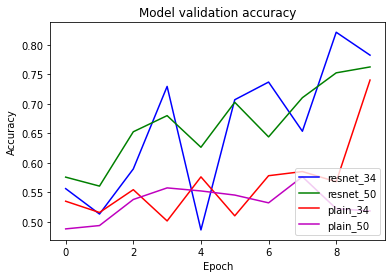

In [26]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

## 04. 회고

1. LearningRateScheduler
    - 논문 상에서는 learnigrate을 plateau가 있을 때 일정 비율로 줄여준다고 하였다. model에서 구현은 하지 못했지만 callback함수를 이용하면 된다고 한다.
2. 학습시간
    - 더많은 epoch으로 차이를 확연하게 비교하고 싶었지만 학습시간이 생각보다 시간이 걸려 확인은 하지 못했다.
3. 성능차이
    - resnet으로 구현한 것이 plain보다 성능이 좋았다. epoch이 길어질수록 더 확연한 차이가 발생할 것이라고 예상이 된다.